In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,classification_report
from sklearn.model_selection import StratifiedShuffleSplit
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import pyodbc 
from sklearn.dummy import DummyClassifier

In [63]:
server = 'hvs-ssis5,1433'
database = 'common' # enter database name
cnxn=pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';Trusted_Connection=Yes')

voter_sample = pd.read_sql("""SELECT top 20000 * from voter_sample_100k order by newid()""", cnxn) 

predictit_data = pd.read_sql("""SELECT top 30000 * from predictit_matched_20240206 order by newid()""", cnxn)

cnxn.close()

C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_8592\2138630262.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  voter_sample = pd.read_sql("""SELECT top 20000 * from voter_sample_100k order by newid()""", cnxn)
C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_8592\2138630262.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  predictit_data = pd.read_sql("""SELECT top 30000 * from predictit_matched_20240206 order by newid()""", cnxn)


In [64]:
#keep only the active users in the predictit sample

for column in ['deposits', 'accountbalance', 'Withdrawals', 'Invested', 'riskamount', 'profit', 'loss','numshares']:
    predictit_data[column] = pd.to_numeric(predictit_data[column])
    
condition = (
    (predictit_data['deposits'] != 0) |
    (predictit_data['accountbalance'] != 0) |
    (predictit_data['Withdrawals'] != 0.00) |
    (predictit_data['Invested'] != 0.00) |
    (predictit_data['numshares'] != 0) |  
    (predictit_data['riskamount'] != 0.0000) |
    (predictit_data['profit'] != 0.000000) |
    (predictit_data['loss'] != 0.000000)
)

predictit_data = predictit_data[condition].copy()

In [65]:
len(predictit_data)

19828

## create a balanced training data set of half predictit users and have random voters.

In [66]:
predictit_sample = predictit_data.sample(n=19000, random_state=42)
voter_sample  = voter_sample.sample(n=19000, random_state=42)

# Create a column in each DataFrame to indicate the source
# Set 'predictit_user' to 1 for records from predictit_data, and to 0 for records from voter_sample
predictit_sample['predictit_user'] = 1
voter_sample['predictit_user'] = 0

# Since there are some columns in predictit_data that aren't in voter_sample, align the columns
# We do this by selecting only the columns present in voter_sample (excluding 'predictit_user' which we just added)
columns_to_keep = voter_sample.columns.tolist()  # This gets the column names from voter_sample
predictit_sample_aligned = predictit_sample[columns_to_keep]  # Select only the shared columns plus the new one

# Now concatenate the two DataFrames
training_data = pd.concat([predictit_sample_aligned, voter_sample], ignore_index=True)


In [67]:
training_data['predictit_user'].value_counts()

1    19000
0    19000
Name: predictit_user, dtype: int64

## Feature Engineering

In [68]:
#Replace blanks and spaces with NaN
training_data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#consolidate SEX values due to some casing issues.
training_data['SEX'] = training_data['SEX'].replace({'f': 'F', 'm': 'M', 'N': 'U', ' ': 'U'})

# Mapping the PARTY_CODE to new groups
party_code_mapping = {
    'R': 'Republican', 'S': 'Republican',
    'D': 'Democrat', 'E': 'Democrat',
    'N': 'No Affiliation', 'U': 'Unknown'
}

# If the party code is not in the mapping, assign 'O' (other)
training_data['GROUPED_PARTY'] = training_data['PARTY_CODE'].map(party_code_mapping).fillna('Other')

C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_8592\3192406077.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  training_data['GROUPED_PARTY'] = training_data['PARTY_CODE'].map(party_code_mapping).fillna('Other')


In [69]:
# Convert numeric fields to float
for column in training_data.columns:
    # Check if all values in the column are numeric
    if training_data[column].apply(lambda x: str(x).replace('.', '', 1).isdigit()).all():
        training_data[column] = training_data[column].astype(float)
    # Check for fields where the only values are 'Y' and NaN
    elif set(training_data[column].dropna().unique()) == {'Y'}:
        training_data[column] = training_data[column].map({'Y': 1, np.nan: 0}).astype(int)
        training_data[column] = training_data[column].astype(float)

In [70]:
#impute missing values

for column in training_data.columns:
    # Check if the column is numeric
    if training_data[column].dtype in ['float64', 'int64']:
        # Impute missing values with median
        median_val = training_data[column].median()
        training_data[column].fillna(median_val, inplace=True)
    else:
        # Impute missing values with mode
        mode_val = training_data[column].mode().iloc[0]
        training_data[column].fillna(mode_val, inplace=True)

C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [71]:
#fill any columns that are all empty with 0
for column in training_data.columns:
    # Check if all values in the column are NaN
    if training_data[column].isna().all():
        training_data[column] = training_data[column].fillna(0)

In [72]:
#got below list from the EDA

In [73]:
features_to_use =['AGE','ZIP','MEDHOMEVAL','SEX','OCCDETAIL','OCCDETAIL_DESC','LIFESTAGE_CLUSTER','CNS_MEDINC','GENDER_MIX',
'CNSUS_PCTB','AGE_IND','GENERATION','TOD_SEN_R_2020','HOMEMKTVAL','TOD_SEN_D_2020','AI_County_Name',
'INCOMESTHH','TOD_SEN_D_2014','TOD_SEN_R_2014','TOD_PRES_R_2020','VP_GEN','TOD_PRES_D_2020','TOD_PRES_R_2016',
'TOD_PRES_D_2016','AUTO_MODEL','TOD_GOV_R_2018','TOD_PRES_R_2012','CNSUS_PCTA','TOD_PRES_D_2012','TOD_SEN_R_2012',
'TOD_GOV_D_2018','TOD_SEN_D_2012','TOD_SEN_R_2018','TOD_SEN_R_2016','NETWORTH','TOD_GOV_R_2014','TOD_SEN_D_2018',
'TOD_GOV_D_2014','TOD_SEN_D_2016','TOD_SEN_DIFF_2020','TOD_PRES_DIFF_2020','EDUCATION','TOD_PRES_DIFF_2016','OCCUPATION',
'WEALTH','TOD_SEN_DIFF_2014','TOD_SEN_DIFF_2016','TOD_PRES_R_2020_PREC','CNSUS_PCTW']

X = training_data[features_to_use] 
y = training_data['predictit_user']

In [74]:
#first split - validation set
X_temp, X_validation, y_temp, y_validation = train_test_split(X, y, test_size=0.1, random_state=42) # 10% for validation

#Second split: Splitting the remaining data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42) # 20% of 90% for testing

# Label Encoding

In [75]:
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [76]:
# Initialize the label encoders dictionary
label_encoders = {}

# Encoding each categorical column in the training set and applying it to test and validation sets
for col in categorical_columns:
    # Initialize the LabelEncoder
    le = LabelEncoder()

    # Fit on the training data
    le.fit(X_train[col].astype(str))

    # Transform training, test, and validation data using the fitted encoder
    # Unseen categories in test and validation sets are replaced with -1
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = X_test[col].map(lambda s: le.transform([str(s)]) if str(s) in le.classes_ else -1).astype(int)
    X_validation[col] = X_validation[col].map(lambda s: le.transform([str(s)]) if str(s) in le.classes_ else -1).astype(int)

    # Store the LabelEncoder for later use
    label_encoders[col] = le


In [77]:
#train a dummy classifier

dummy_clf = DummyClassifier(strategy='stratified')

# Train the DummyClassifier on the training data
dummy_clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = dummy_clf.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Baseline accuracy of DummyClassifier: {accuracy}')

Baseline accuracy of DummyClassifier: 0.50453216374269


In [78]:
#initialize and train logistic regression model
lr_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
lr_pipeline.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = lr_pipeline.predict(X_test)
print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Test Set Evaluation:
Accuracy: 0.7567251461988304
              precision    recall  f1-score   support

         0.0       0.78      0.71      0.74      3381
         1.0       0.74      0.80      0.77      3459

    accuracy                           0.76      6840
   macro avg       0.76      0.76      0.76      6840
weighted avg       0.76      0.76      0.76      6840



In [79]:
# Perform 10-fold cross-validation
scoring = {'accuracy': 'accuracy', 'precision': 'precision_macro', 'f1': 'f1_macro'}
cv_results = cross_validate(lr_pipeline, X_train, y_train, cv=10, scoring=scoring)

# Print the average of the evaluation metrics across all 10 folds
print("10-Fold Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Average Precision (macro): {np.mean(cv_results['test_precision']):.3f}")
print(f"Average F1-Score (macro): {np.mean(cv_results['test_f1']):.3f}")

10-Fold Cross-Validation Results:
Average Accuracy: 0.765
Average Precision (macro): 0.766
Average F1-Score (macro): 0.765


In [80]:
#validation set testing
y_validation_pred = lr_pipeline.predict(X_validation)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print(classification_report(y_validation, y_validation_pred))

Validation Set Evaluation:
Accuracy: 0.766578947368421
              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76      1902
         1.0       0.75      0.80      0.77      1898

    accuracy                           0.77      3800
   macro avg       0.77      0.77      0.77      3800
weighted avg       0.77      0.77      0.77      3800



In [81]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
#rf_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier())
rf_pipeline = RandomForestClassifier()
rf_pipeline.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_rf = rf_pipeline.predict(X_test)
print("Random Forest Model Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Model Test Set Evaluation:
Accuracy: 0.7701754385964912
              precision    recall  f1-score   support

         0.0       0.77      0.76      0.77      3381
         1.0       0.77      0.78      0.77      3459

    accuracy                           0.77      6840
   macro avg       0.77      0.77      0.77      6840
weighted avg       0.77      0.77      0.77      6840



In [82]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train the Gradient Boosted Decision Tree model

gbdt_pipeline =  GradientBoostingClassifier()
gbdt_pipeline.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_gbdt = gbdt_pipeline.predict(X_test)
print("Gradient Boosted Decision Tree Model Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_gbdt))
print(classification_report(y_test, y_pred_gbdt))

Gradient Boosted Decision Tree Model Test Set Evaluation:
Accuracy: 0.777046783625731
              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77      3381
         1.0       0.77      0.79      0.78      3459

    accuracy                           0.78      6840
   macro avg       0.78      0.78      0.78      6840
weighted avg       0.78      0.78      0.78      6840



In [83]:
import xgboost as xgb

# Initialize and train the XGBoost model
# Note: XGBClassifier handles data scaling internally, so StandardScaler is not necessary.
xgb_pipeline = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_pipeline.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_xgb = xgb_pipeline.predict(X_test)
print("XGBoost Model Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Model Test Set Evaluation:
Accuracy: 0.7716374269005848
              precision    recall  f1-score   support

         0.0       0.78      0.75      0.76      3381
         1.0       0.76      0.79      0.78      3459

    accuracy                           0.77      6840
   macro avg       0.77      0.77      0.77      6840
weighted avg       0.77      0.77      0.77      6840



In [84]:
# Get predictions for each model
prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]
prob_gbdt = gbdt_pipeline.predict_proba(X_test)[:, 1]
prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]
prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]

# Average the probabilities
average_prob = (prob_xgb + prob_gbdt + prob_rf + prob_lr) / 4

# Convert probabilities to final predictions 
final_predictions = np.where(average_prob > 0.5, 1, 0)

# Evaluate the ensemble model
print("Ensemble Model Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, final_predictions))
print(classification_report(y_test, final_predictions))

Ensemble Model Test Set Evaluation:
Accuracy: 0.7783625730994153
              precision    recall  f1-score   support

         0.0       0.79      0.75      0.77      3381
         1.0       0.77      0.80      0.79      3459

    accuracy                           0.78      6840
   macro avg       0.78      0.78      0.78      6840
weighted avg       0.78      0.78      0.78      6840



In [ ]:
#ok this is pretty good start with the modeling so far i think 

In [85]:
#gradient boosting is doing the best, check 10 fold cross validation on that one

# Perform 10-fold cross-validation
scoring = {'accuracy': 'accuracy', 'precision': 'precision_macro', 'f1': 'f1_macro'}
cv_results = cross_validate(gbdt_pipeline, X_train, y_train, cv=10, scoring=scoring)

# Print the average of the evaluation metrics across all 10 folds
print("10-Fold Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Average Precision (macro): {np.mean(cv_results['test_precision']):.3f}")
print(f"Average F1-Score (macro): {np.mean(cv_results['test_f1']):.3f}")

10-Fold Cross-Validation Results:
Average Accuracy: 0.781
Average Precision (macro): 0.781
Average F1-Score (macro): 0.781


In [86]:
#and evaluate the validation test set

y_validation_pred = gbdt_pipeline.predict(X_validation)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print(classification_report(y_validation, y_validation_pred))

Validation Set Evaluation:
Accuracy: 0.7871052631578948
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.79      1902
         1.0       0.78      0.79      0.79      1898

    accuracy                           0.79      3800
   macro avg       0.79      0.79      0.79      3800
weighted avg       0.79      0.79      0.79      3800



In [ ]:
#ok so the gbdt is giving us 78% cross fold validation and 78.7% on the validation set.
# let's look at hyper-parameter tuning next for this one.

In [87]:
#let's try a grid search 
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],  
    'n_estimators': [100, 200, 300],    
    'max_depth': [3, 4, 5],             
    
}

# Initialize the classifier
gbdt = GradientBoostingClassifier()

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=gbdt, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

# Use the best estimator to make predictions on the test set
best_gbdt = grid_search.best_estimator_
y_pred_gbdt = best_gbdt.predict(X_test)

# Evaluate the best model found by GridSearchCV
print("Gradient Boosted Decision Tree Model Test Set Evaluation After Hyperparameter Tuning:")
print("Accuracy:", accuracy_score(y_test, y_pred_gbdt))
print(classification_report(y_test, y_pred_gbdt))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best accuracy found:  0.7825657894736843
Gradient Boosted Decision Tree Model Test Set Evaluation After Hyperparameter Tuning:
Accuracy: 0.7741228070175439
              precision    recall  f1-score   support

         0.0       0.78      0.75      0.77      3381
         1.0       0.77      0.79      0.78      3459

    accuracy                           0.77      6840
   macro avg       0.77      0.77      0.77      6840
weighted avg       0.77      0.77      0.77      6840



In [ ]:
# ok this is weird because the smaller data set had a better result

In [ ]:
#default for smaller data set was

#Gradient Boosted Decision Tree Model Test Set Evaluation:
#Accuracy: 0.7841666666666667
#              precision    recall  f1-score   support
#
#         0.0       0.79      0.79      0.79      1831
#         1.0       0.78      0.78      0.78      1769
#
#    accuracy                           0.78      3600
#   macro avg       0.78      0.78      0.78      3600
#weighted avg       0.78      0.78      0.78      3600

#so the tuned performance is only a tiny bit better

In [88]:
# Perform 10-fold cross-validation
scoring = {'accuracy': 'accuracy', 'precision': 'precision_macro', 'f1': 'f1_macro'}
cv_results = cross_validate(best_gbdt, X_train, y_train, cv=10, scoring=scoring)

# Print the average of the evaluation metrics across all 10 folds
print("10-Fold Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Average Precision (macro): {np.mean(cv_results['test_precision']):.3f}")
print(f"Average F1-Score (macro): {np.mean(cv_results['test_f1']):.3f}")

10-Fold Cross-Validation Results:
Average Accuracy: 0.782
Average Precision (macro): 0.783
Average F1-Score (macro): 0.782


In [ ]:
#thats weird, maybe i just got a bad split idk. this is better. but still not quite as good as before.

In [89]:
# in the real world the classes are going to be very imbalanced, therefore i want to split the validation data by the classes
#to create an imbalanced validation set to make predictions on and then we will see how it does.


# Convert to DataFrame for easier manipulation 
X_validation_df = pd.DataFrame(X_validation)
y_validation_df = y_validation.to_frame()

# Combine them back for easy manipulation
validation_data = pd.concat([X_validation_df, y_validation_df], axis=1)

# Split based on class
class_0 = validation_data[validation_data['predictit_user'] == 0.0]
class_1 = validation_data[validation_data['predictit_user'] == 1.0]

# Sample from class_0 more heavily than class_1 to create an unbalanced dataset
class_0_sample = class_0.sample(frac=0.9, random_state=42)  # Sample 90% of class 0
class_1_sample = class_1.sample(frac=0.1, random_state=42)  # Sample 10% of class 1

# Combine back into a single DataFrame
unbalanced_validation_data = pd.concat([class_0_sample, class_1_sample], axis=0)

# Split the features and labels
X_unbalanced_validation = unbalanced_validation_data.drop('predictit_user', axis=1)
y_unbalanced_validation = unbalanced_validation_data['predictit_user']



In [90]:
# Predict on the unbalanced dataset
y_unbalanced_validation_pred = best_gbdt.predict(X_unbalanced_validation)

# Evaluate the model
print("Unbalanced Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_unbalanced_validation, y_unbalanced_validation_pred))
print(classification_report(y_unbalanced_validation, y_unbalanced_validation_pred))

Unbalanced Validation Set Evaluation:
Accuracy: 0.7723449001051524
              precision    recall  f1-score   support

         0.0       0.97      0.77      0.86      1712
         1.0       0.27      0.77      0.40       190

    accuracy                           0.77      1902
   macro avg       0.62      0.77      0.63      1902
weighted avg       0.90      0.77      0.81      1902



Okay so we have high recall and low precision for class 1 in the imbalanced data set. So it's correctly identifying 77% of the actual class 1 instances, but then also identifying a lot of false positives as being class 1 that are not. However, I am not sure this is a bad thing necessarily if we're looking to cast a wide net for marketing purposes.

In [91]:
probabilities = best_gbdt.predict_proba(X_validation)

# Set a new threshold
threshold = 0.7  

# Apply the new threshold to determine class labels
predicted_classes = (probabilities[:, 1] >= threshold).astype(int)

# Evaluate the results with the new threshold
print("Evaluation with adjusted threshold:")
print("Accuracy:", accuracy_score(y_validation, predicted_classes))
print(classification_report(y_validation, predicted_classes))

Evaluation with adjusted threshold:
Accuracy: 0.7455263157894737
              precision    recall  f1-score   support

         0.0       0.69      0.88      0.78      1902
         1.0       0.84      0.61      0.71      1898

    accuracy                           0.75      3800
   macro avg       0.76      0.75      0.74      3800
weighted avg       0.76      0.75      0.74      3800



Using an altered threshhold would be a possibility, as it increases the precision of class 1 , so it might be appropriate in the context of a targeting marketing campaign.

In [ ]:
# we also want to do a learning curve 

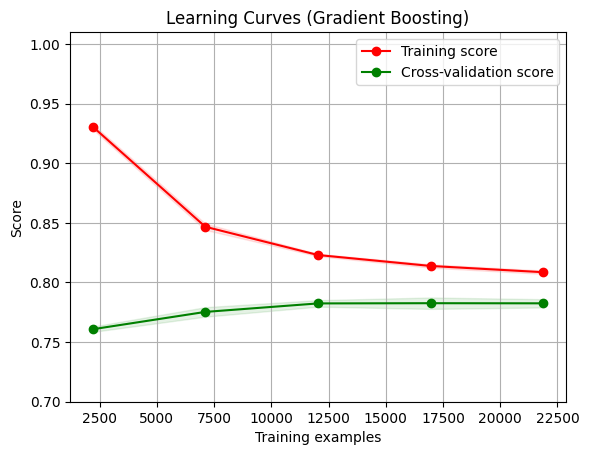

In [92]:

from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, random_state=42)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (Gradient Boosting)"
# Cross-validation with 5 splits
cv = 5
# Evaluate score on training and test set several times with different training set sizes
plot_learning_curve(best_gbdt, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

# Display the plot
plt.show()


ok it looks like adding more training data does not help after about 13,000 records. 

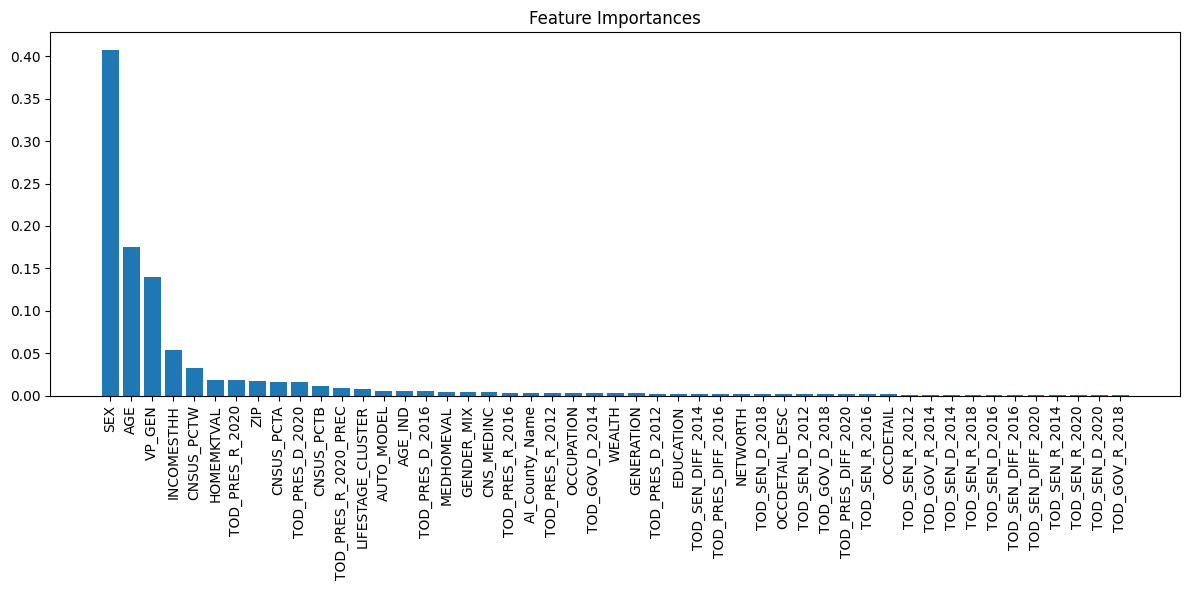

In [93]:
#feature importances

# Get feature importances from the model
feature_importances = best_gbdt.feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Create labels for the x-axis with the feature names
sorted_feature_names = [features_to_use[i] for i in sorted_indices]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(sorted_indices)), sorted_feature_names, rotation=90)
plt.tight_layout()
plt.show()


OK this makes sense, guess we're definitely going after some white/ asian males of a certain age, income, geo , voting propensity

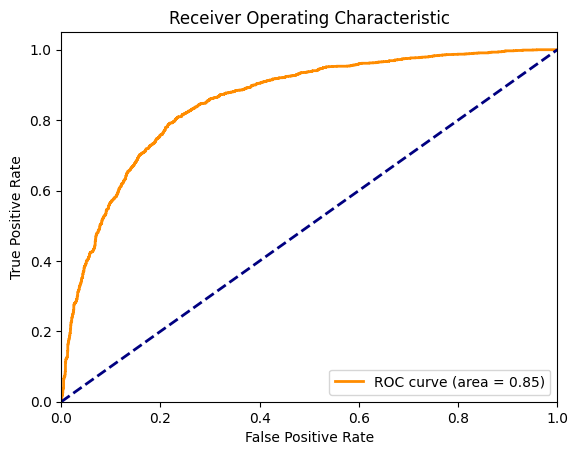

In [94]:
#Roc-AUC curve

from sklearn.metrics import roc_curve, auc


# Compute the model's prediction probabilities
y_scores = best_gbdt.predict_proba(X_validation)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_validation, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


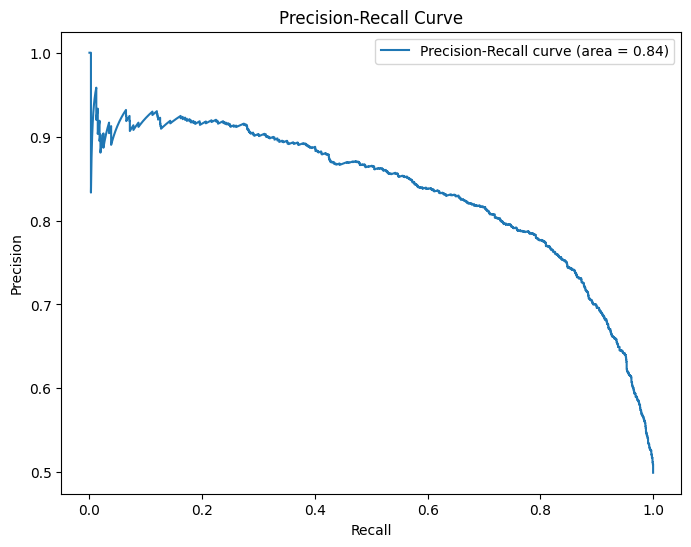

In [95]:
from sklearn.metrics import precision_recall_curve


# Get the probability scores of the positive class
y_scores = best_gbdt.predict_proba(X_validation)[:, 1]

# Calculate precision and recall for various threshold values
precision, recall, thresholds = precision_recall_curve(y_validation, y_scores)

# Calculate the area under the curve as a single scalar value
auc_precision_recall = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (area = {auc_precision_recall:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()


In [96]:
# thoughts- i tried nearly doubling the training data and that didn't improve performance. will probably go back to around
# 13,000 training records. and maybe look at features again and see if there's any more i should add or engineer.